In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [2]:
# 2. Load dataset
df = pd.read_csv("crop_yield_with_carbon_footprint.csv")


In [3]:
# 4. Drop CO2_Fertilizer and CO2_Pesticide columns
df.drop(columns=["CO2_Fertilizer", "CO2_Pesticide"],inplace=True)

In [4]:
# Fill missing values in numeric columns with median
numeric_cols = df.select_dtypes(include=["number"]).columns
for col in numeric_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Fill missing values in categorical columns with mode
categorical_cols = df.select_dtypes(exclude=["number"]).columns
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

In [5]:

# 5. Standardize text columns
for col in ["Crop", "Season", "State"]:
    df[col] = df[col].astype(str).str.strip().str.title()

# 6. Remove negative values
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df = df[df[col] >= 0]


In [6]:
# 7. Outlier removal (IQR)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in ["Area", "Production", "Yield", "Fertilizer", "Pesticide", 
            "CO2_Emissions", "Carbon_Footprint"]:
    df = remove_outliers(df, col)

print("✅ Dataset shape after cleaning:", df.shape)


✅ Dataset shape after cleaning: (8436, 12)


In [7]:
# -------- Encoding Categorical Columns --------
label_encoders = {}
for col in ["Crop", "State", "Season"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# -------- Features and Target --------
X = df.drop("Carbon_Footprint", axis=1)
y = df["Carbon_Footprint"]

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
# -------- Hyperparameter tuning for Random Forest --------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("\n✅ Best Parameters:", grid_search.best_params_)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
152 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\DELL\anaconda3\Lib\site-packages\s


✅ Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [9]:
# -------- Evaluate the best model --------
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n🎯 Model Performance (Random Forest, tuned):")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")



🎯 Model Performance (Random Forest, tuned):
MAE  : 42.1059
MSE  : 5120.1058
RMSE : 71.5549
R²   : 0.9367


In [10]:
# -------- Safe transform function --------
def safe_transform(le, value):
    if value in le.classes_:
        return le.transform([value])[0]
    else:
        print(f"Warning: '{value}' not in training data. Using -1.")
        return -1



In [11]:
# -------- Example prediction --------
example = pd.DataFrame({
    "Crop": [safe_transform(label_encoders["Crop"], "Rice")],
    "State": [safe_transform(label_encoders["State"], "Andhra Pradesh")],
    "Season": [safe_transform(label_encoders["Season"], "Winter")],
    "Crop_Year": [2015],
    "Area": [1200],
    "Production": [3500],
    "Annual_Rainfall": [950],
    "Fertilizer": [11000],
    "Pesticide": [280],
    "Yield": [3000],
    "CO2_Fertilizer": [100000],
    "CO2_Pesticide": [2000],
    "CO2_Emissions": [50000]
})

example = example[X.columns]
predicted_cf = best_model.predict(example)[0]
print("\nPredicted Carbon_Footprint:",predicted_cf)


Predicted Carbon_Footprint: 172.1931418103074


C:\Users\DELL\AppData\Local\Temp\ipykernel_13856\3284887717.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["carbon_footprint"] = df["carbon_footprint"].fillna(df["carbon_footprint"].median())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13856\3284887717.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


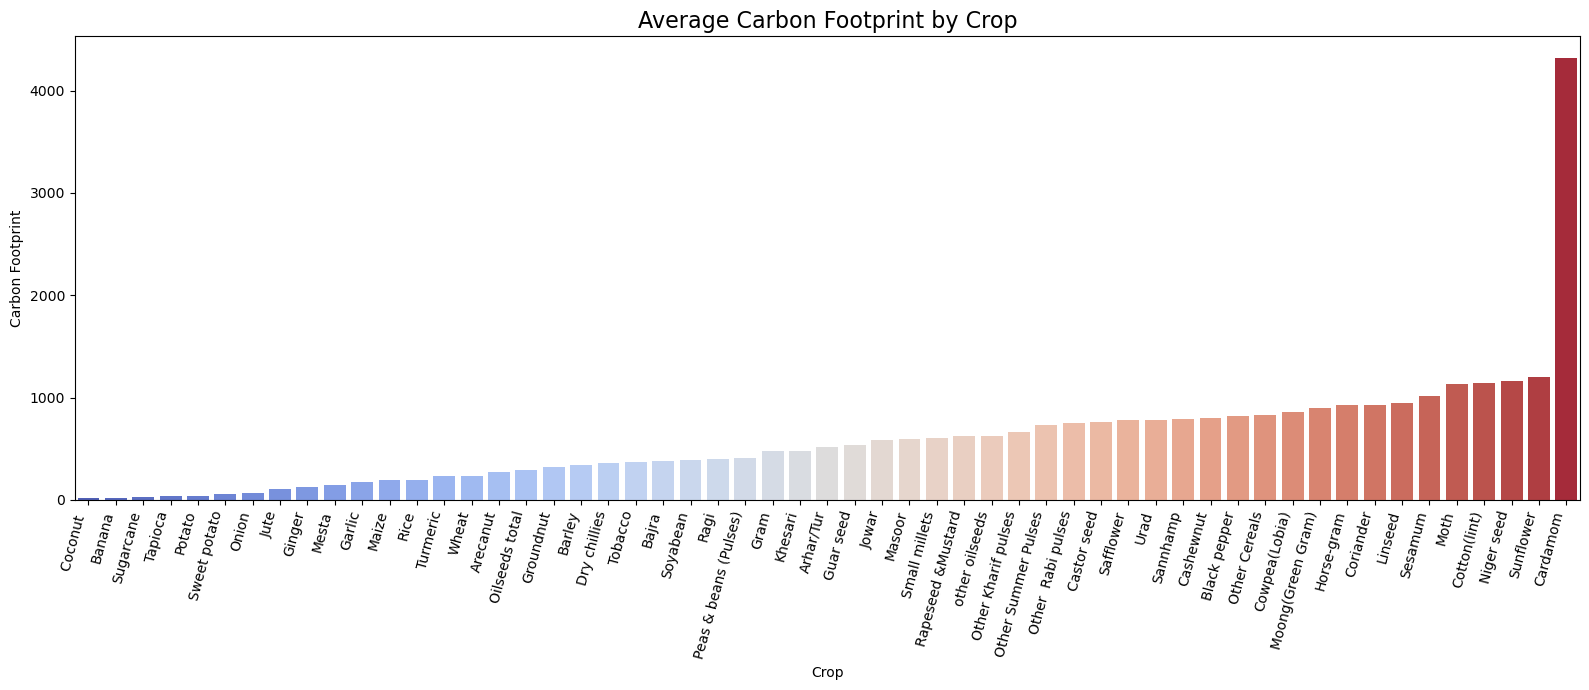

🌱 Crop with MIN Carbon Footprint: Coconut  = 14.34228885987467
🔥 Crop with MAX Carbon Footprint: Cardamom = 4315.429089500132


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize column names
df.columns = [c.lower() for c in df.columns]

# Clean numeric columns (remove inf/nan)
df["carbon_footprint"] = pd.to_numeric(df["carbon_footprint"], errors="coerce")
df["carbon_footprint"] = df["carbon_footprint"].replace([float("inf"), -float("inf")], pd.NA)
df["carbon_footprint"] = df["carbon_footprint"].fillna(df["carbon_footprint"].median())

# Group crop-wise averages
crop_carbon = df.groupby("crop")["carbon_footprint"].mean().reset_index()

# Sort by carbon footprint
crop_carbon = crop_carbon.sort_values("carbon_footprint").reset_index(drop=True)

# Plot
plt.figure(figsize=(16, 7))
sns.barplot(
    data=crop_carbon,
    x="crop", 
    y="carbon_footprint", 
    palette="coolwarm"
)
plt.xticks(rotation=75, ha="right")
plt.title("Average Carbon Footprint by Crop", fontsize=16)
plt.ylabel("Carbon Footprint")
plt.xlabel("Crop")
plt.tight_layout()
plt.show()

# Print min and max values
min_crop = crop_carbon.loc[crop_carbon["carbon_footprint"].idxmin()]
max_crop = crop_carbon.loc[crop_carbon["carbon_footprint"].idxmax()]

print(f"🌱 Crop with MIN Carbon Footprint: {min_crop['crop']} = {min_crop['carbon_footprint']}")
print(f"🔥 Crop with MAX Carbon Footprint: {max_crop['crop']} = {max_crop['carbon_footprint']}")

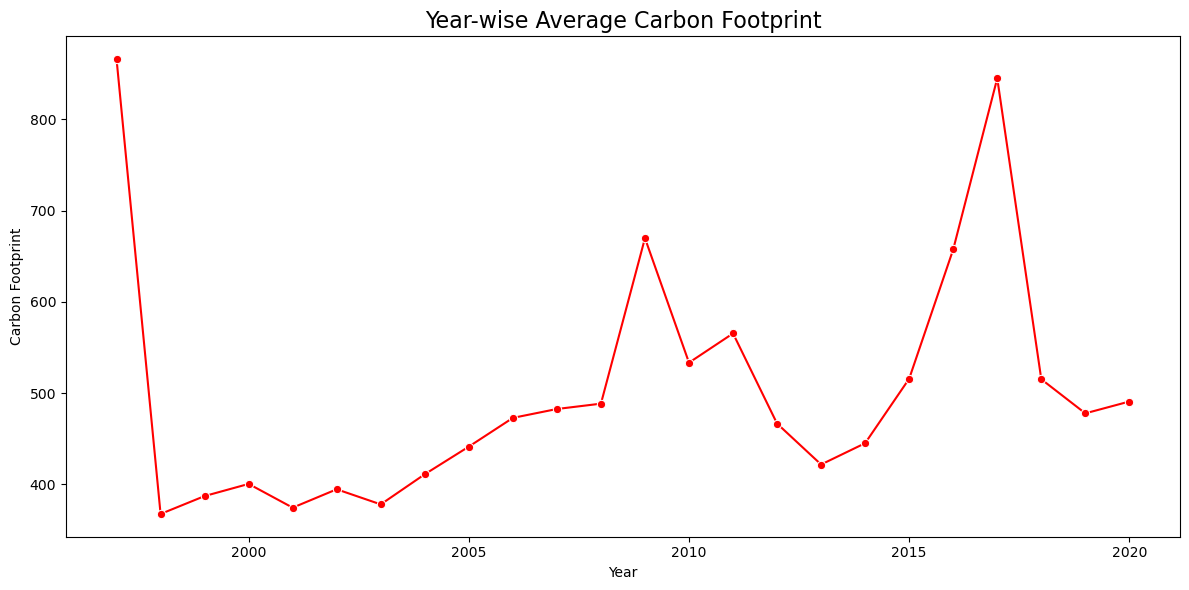

📅 Year with MIN Carbon Footprint: 1998.0 = 367.4524036010736
📅 Year with MAX Carbon Footprint: 1997.0 = 866.0577083321269


In [60]:
# 2. Year-wise Average Carbon Footprint
# ===============================
year_carbon = df.groupby("crop_year")["carbon_footprint"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_carbon, x="crop_year", y="carbon_footprint", marker="o", color="red")
plt.title("Year-wise Average Carbon Footprint", fontsize=16)
plt.ylabel("Carbon Footprint")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

min_year = year_carbon.loc[year_carbon["carbon_footprint"].idxmin()]
max_year = year_carbon.loc[year_carbon["carbon_footprint"].idxmax()]
print(f"📅 Year with MIN Carbon Footprint: {min_year['crop_year']} = {min_year['carbon_footprint']}")
print(f"📅 Year with MAX Carbon Footprint: {max_year['crop_year']} = {max_year['carbon_footprint']}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_13856\400816052.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_co2, x="crop", y="co2_emissions", palette="viridis")


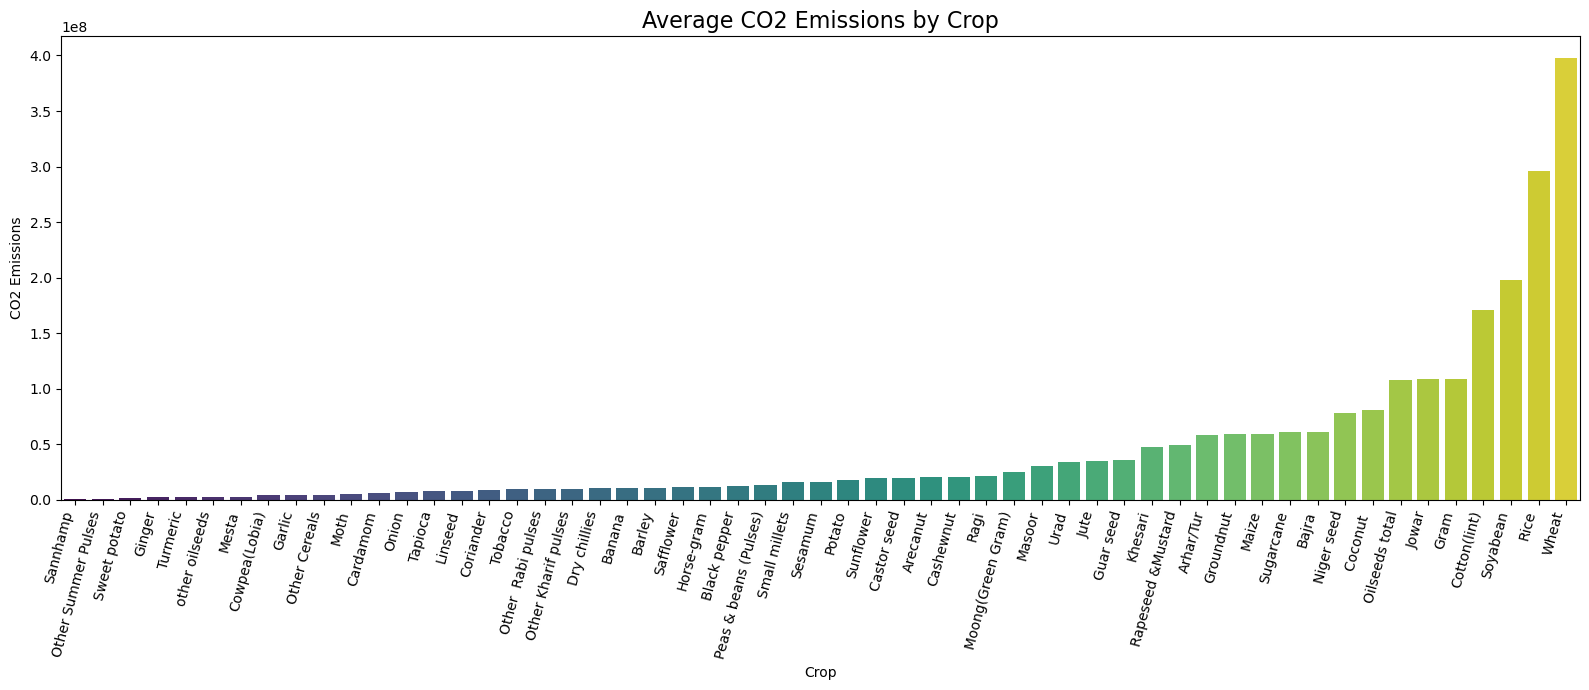

🌱 Crop with MIN CO2 Emissions: Sannhamp = 597726.7053875
🔥 Crop with MAX CO2 Emissions: Wheat = 397376640.45018595


In [61]:
# 3. Crop-wise Average CO2 Emissions
# ===============================
crop_co2 = df.groupby("crop")["co2_emissions"].mean().reset_index()
crop_co2 = crop_co2.sort_values("co2_emissions").reset_index(drop=True)

plt.figure(figsize=(16, 7))
sns.barplot(data=crop_co2, x="crop", y="co2_emissions", palette="viridis")
plt.xticks(rotation=75, ha="right")
plt.title("Average CO2 Emissions by Crop", fontsize=16)
plt.ylabel("CO2 Emissions")
plt.xlabel("Crop")
plt.tight_layout()
plt.show()

min_crop = crop_co2.loc[crop_co2["co2_emissions"].idxmin()]
max_crop = crop_co2.loc[crop_co2["co2_emissions"].idxmax()]
print(f"🌱 Crop with MIN CO2 Emissions: {min_crop['crop']} = {min_crop['co2_emissions']}")
print(f"🔥 Crop with MAX CO2 Emissions: {max_crop['crop']} = {max_crop['co2_emissions']}")

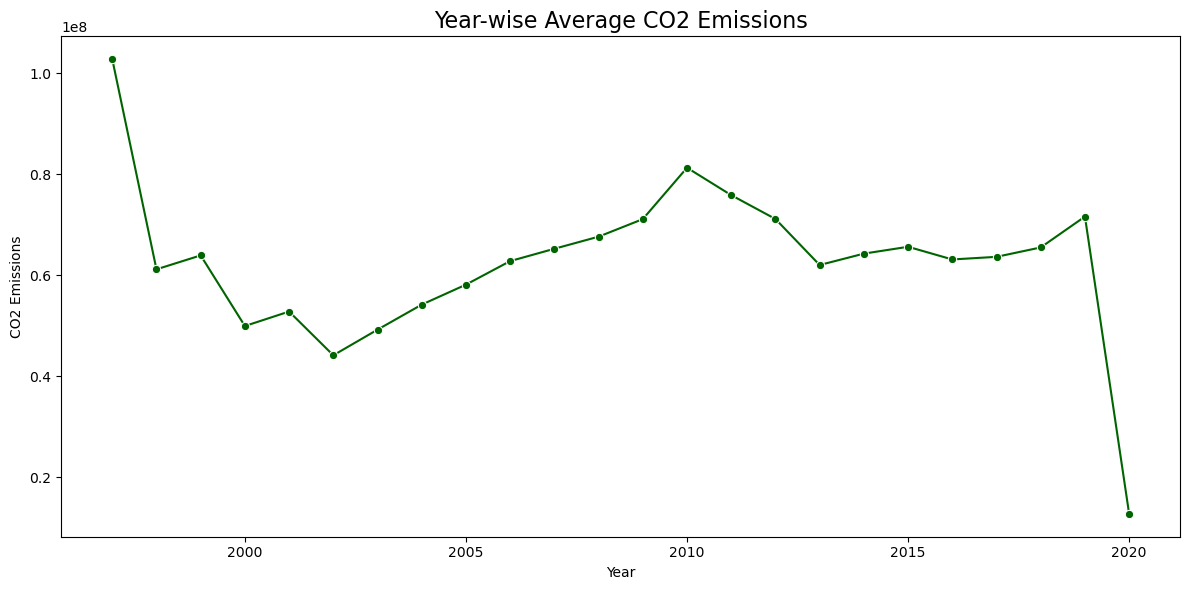

📅 Year with MIN CO2 Emissions: 2020.0 = 12774326.865243241
📅 Year with MAX CO2 Emissions: 1997.0 = 102780448.01694146


In [64]:
# 4. Year-wise Average CO2 Emissions
# ===============================
year_co2 = df.groupby("crop_year")["co2_emissions"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_co2, x="crop_year", y="co2_emissions", marker="o", color="darkgreen")
plt.title("Year-wise Average CO2 Emissions", fontsize=16)
plt.ylabel("CO2 Emissions")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

min_year = year_co2.loc[year_co2["co2_emissions"].idxmin()]
max_year = year_co2.loc[year_co2["co2_emissions"].idxmax()]
print(f"📅 Year with MIN CO2 Emissions: {min_year['crop_year']} = {min_year['co2_emissions']}")
print(f"📅 Year with MAX CO2 Emissions: {max_year['crop_year']} = {max_year['co2_emissions']}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_13856\1727239982.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_yield, x="crop", y="yield", palette="Greens")


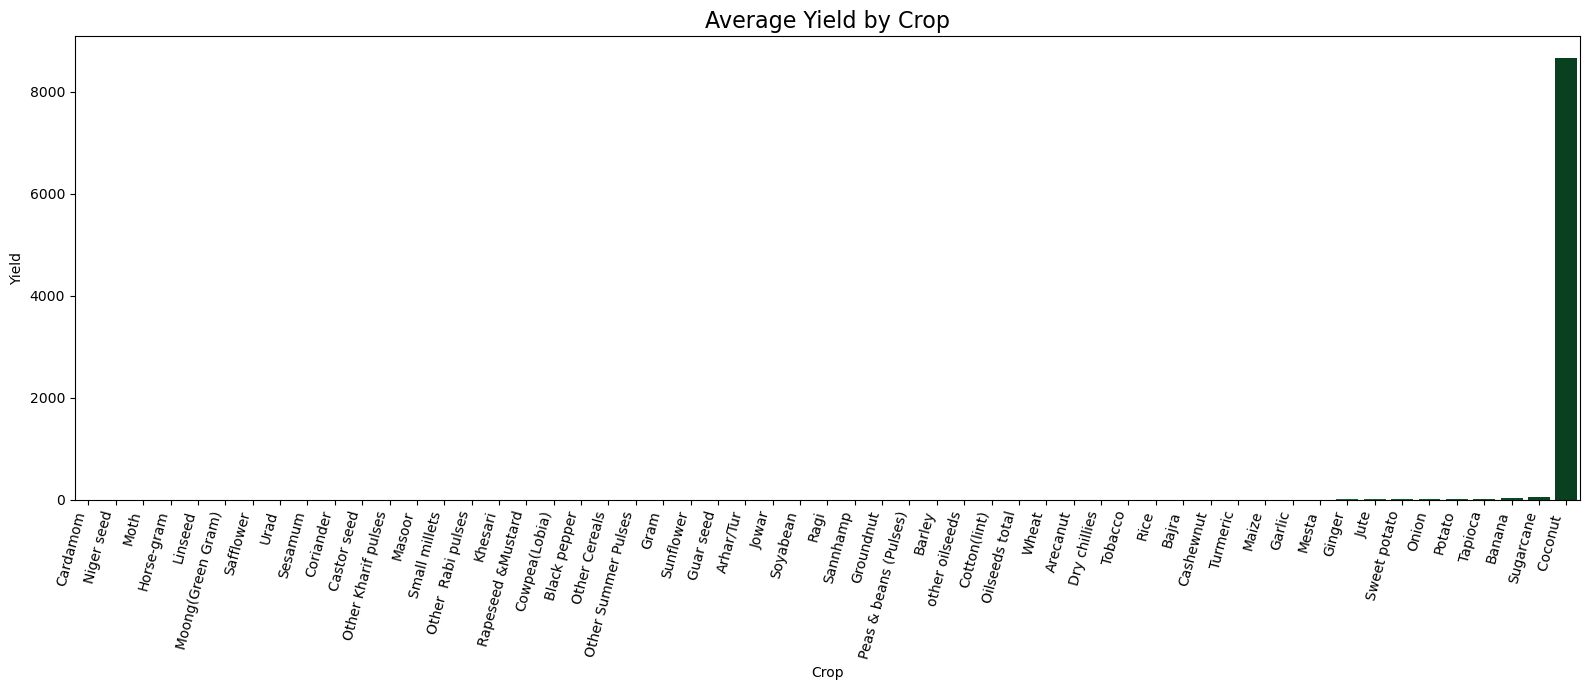

🌱 Crop with MIN Yield: Cardamom = 0.1683552699054054
🔥 Crop with MAX Yield: Coconut  = 8652.000198744186


In [65]:
# 5. Crop-wise Average Yield
# ===============================
crop_yield = df.groupby("crop")["yield"].mean().reset_index()
crop_yield = crop_yield.sort_values("yield").reset_index(drop=True)

plt.figure(figsize=(16, 7))
sns.barplot(data=crop_yield, x="crop", y="yield", palette="Greens")
plt.xticks(rotation=75, ha="right")
plt.title("Average Yield by Crop", fontsize=16)
plt.ylabel("Yield")
plt.xlabel("Crop")
plt.tight_layout()
plt.show()

min_crop = crop_yield.loc[crop_yield["yield"].idxmin()]
max_crop = crop_yield.loc[crop_yield["yield"].idxmax()]
print(f"🌱 Crop with MIN Yield: {min_crop['crop']} = {min_crop['yield']}")
print(f"🔥 Crop with MAX Yield: {max_crop['crop']} = {max_crop['yield']}")

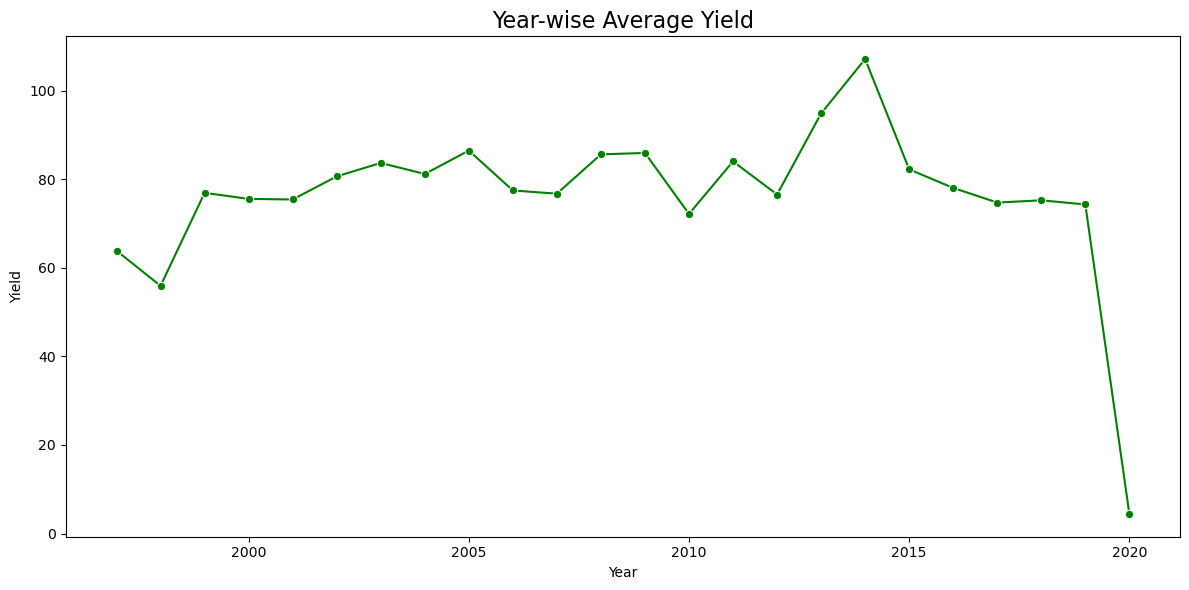

📅 Year with MIN Yield: 2020.0 = 4.420096031918919
📅 Year with MAX Yield: 2014.0 = 107.15031878089844


In [70]:
# 6. Year-wise Average Yield
# ===============================
year_yield = df.groupby("crop_year")["yield"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_yield, x="crop_year", y="yield", marker="o", color="green")
plt.title("Year-wise Average Yield", fontsize=16)
plt.ylabel("Yield")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

min_year = year_yield.loc[year_yield["yield"].idxmin()]
max_year = year_yield.loc[year_yield["yield"].idxmax()]
print(f"📅 Year with MIN Yield: {min_year['crop_year']} = {min_year['yield']}")
print(f"📅 Year with MAX Yield: {max_year['crop_year']} = {max_year['yield']}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_13856\168088828.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_prod, x="crop", y="production", palette="Blues")


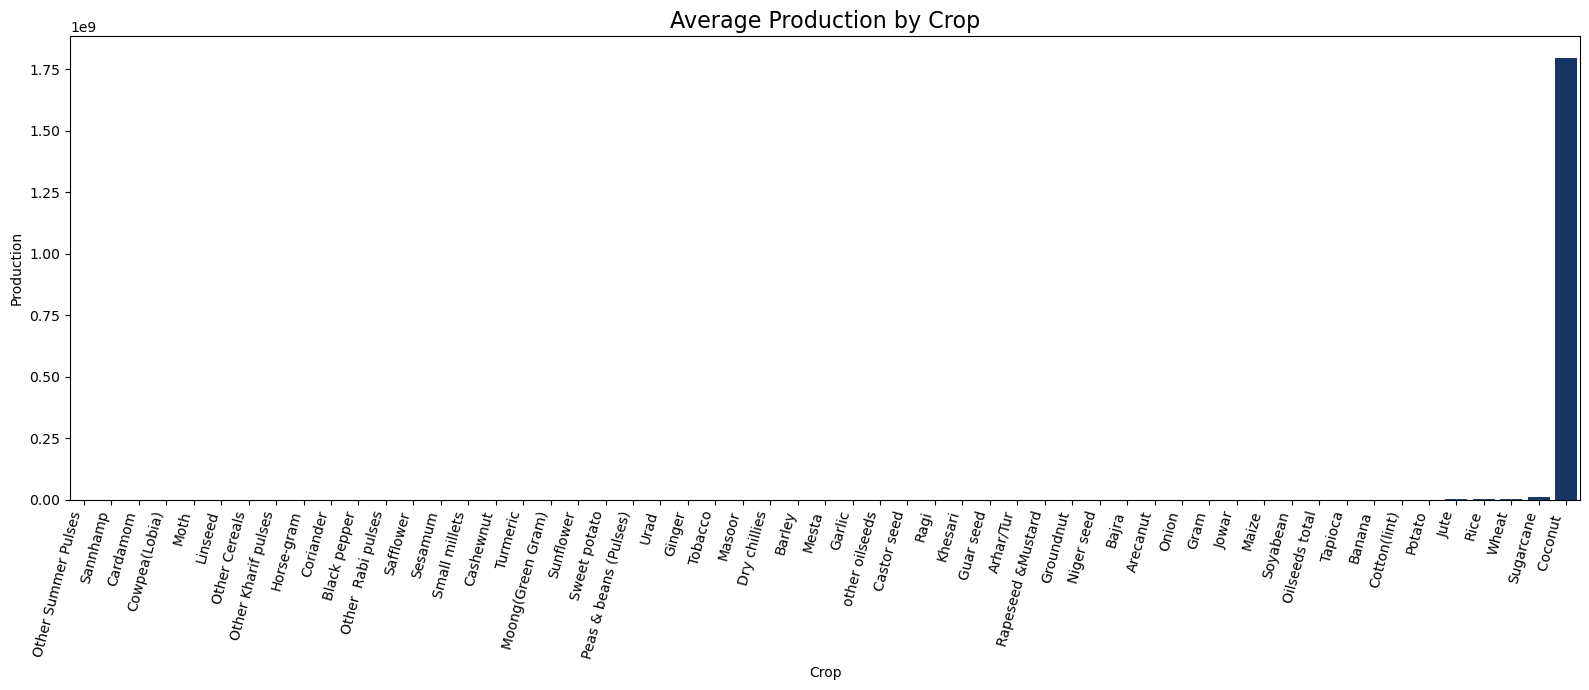

🌱 Crop with MIN Production: Other Summer Pulses = 839.4
🔥 Crop with MAX Production: Coconut  = 1795069594.639535


In [71]:
# 7. Crop-wise Average Production
# ===============================
crop_prod = df.groupby("crop")["production"].mean().reset_index()
crop_prod = crop_prod.sort_values("production").reset_index(drop=True)

plt.figure(figsize=(16, 7))
sns.barplot(data=crop_prod, x="crop", y="production", palette="Blues")
plt.xticks(rotation=75, ha="right")
plt.title("Average Production by Crop", fontsize=16)
plt.ylabel("Production")
plt.xlabel("Crop")
plt.tight_layout()
plt.show()

min_crop = crop_prod.loc[crop_prod["production"].idxmin()]
max_crop = crop_prod.loc[crop_prod["production"].idxmax()]
print(f"🌱 Crop with MIN Production: {min_crop['crop']} = {min_crop['production']}")
print(f"🔥 Crop with MAX Production: {max_crop['crop']} = {max_crop['production']}")


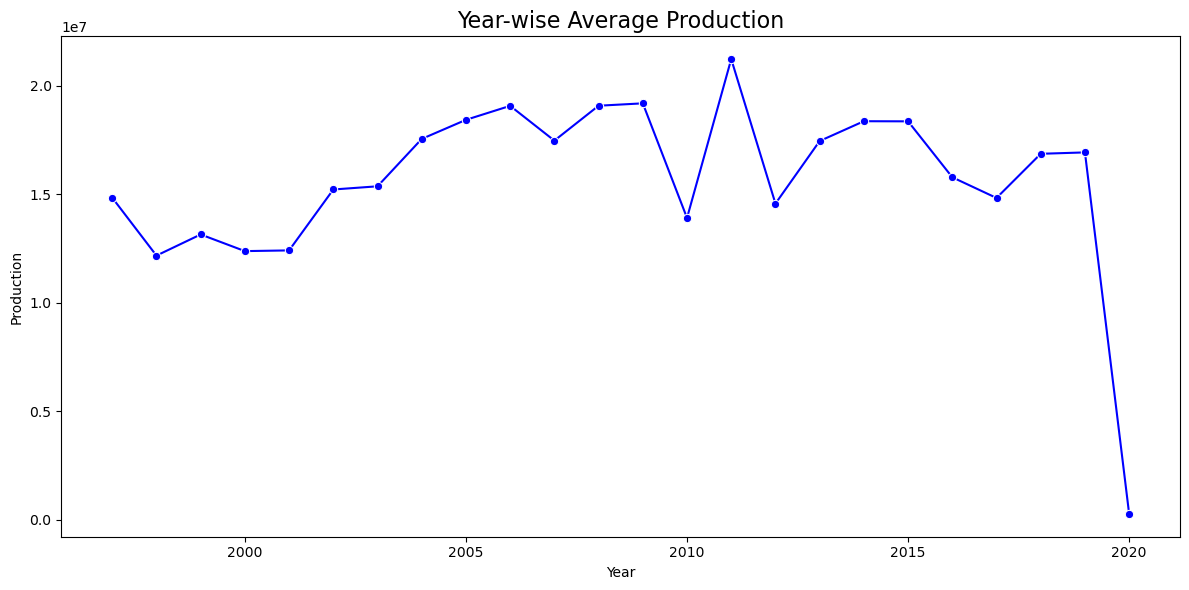

📅 Year with MIN Production: 2020.0 = 275060.1621621622
📅 Year with MAX Production: 2011.0 = 21234972.3969129


In [72]:
# 8. Year-wise Average Production
# ===============================
year_prod = df.groupby("crop_year")["production"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_prod, x="crop_year", y="production", marker="o", color="blue")
plt.title("Year-wise Average Production", fontsize=16)
plt.ylabel("Production")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

min_year = year_prod.loc[year_prod["production"].idxmin()]
max_year = year_prod.loc[year_prod["production"].idxmax()]
print(f"📅 Year with MIN Production: {min_year['crop_year']} = {min_year['production']}")
print(f"📅 Year with MAX Production: {max_year['crop_year']} = {max_year['production']}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_13856\4282799347.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_fert, x="crop", y="fertilizer", palette="Oranges")


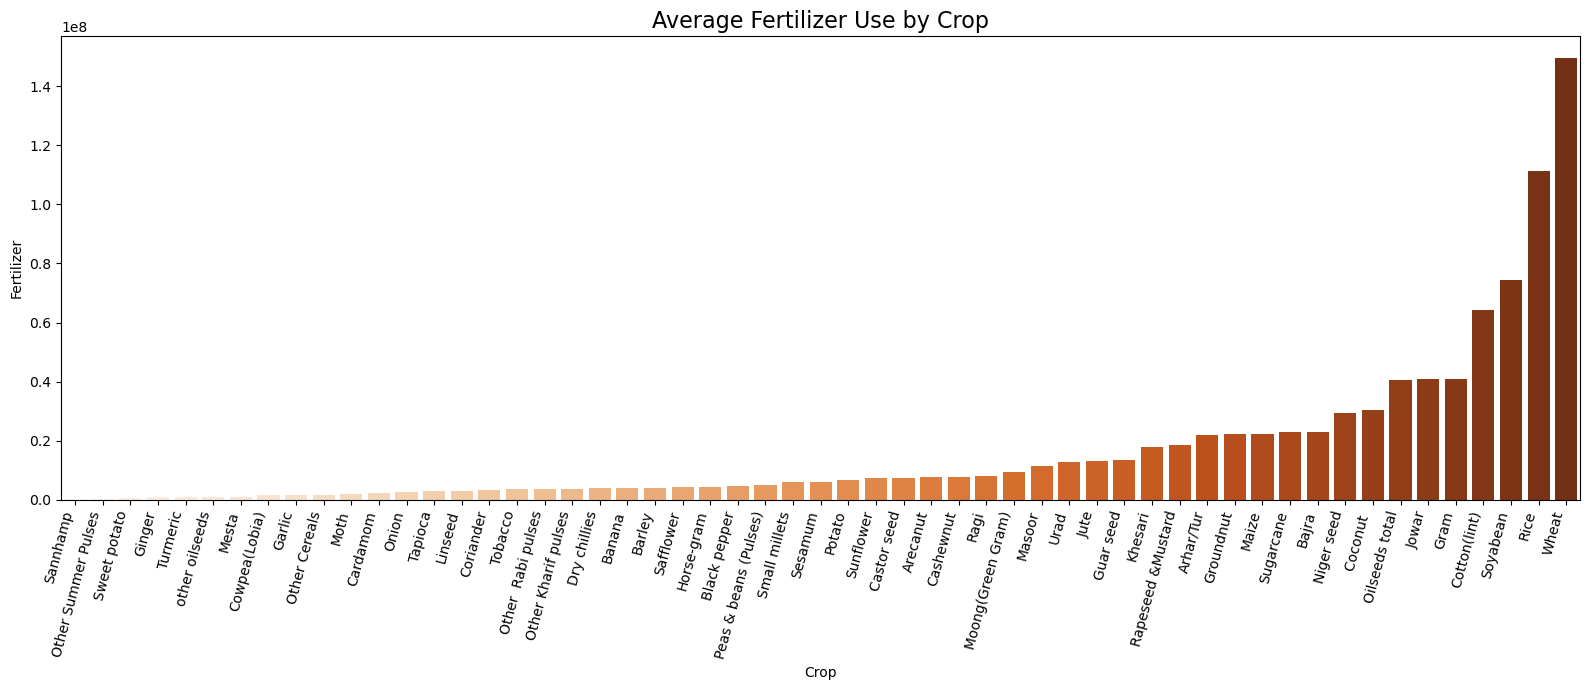

🌱 Crop with MIN Fertilizer: Sannhamp = 224676.11925
🔥 Crop with MAX Fertilizer: Wheat = 149384990.39040184


In [73]:
# 9. Crop-wise Average Fertilizer
# ===============================
crop_fert = df.groupby("crop")["fertilizer"].mean().reset_index()
crop_fert = crop_fert.sort_values("fertilizer").reset_index(drop=True)

plt.figure(figsize=(16, 7))
sns.barplot(data=crop_fert, x="crop", y="fertilizer", palette="Oranges")
plt.xticks(rotation=75, ha="right")
plt.title("Average Fertilizer Use by Crop", fontsize=16)
plt.ylabel("Fertilizer")
plt.xlabel("Crop")
plt.tight_layout()
plt.show()

min_crop = crop_fert.loc[crop_fert["fertilizer"].idxmin()]
max_crop = crop_fert.loc[crop_fert["fertilizer"].idxmax()]
print(f"🌱 Crop with MIN Fertilizer: {min_crop['crop']} = {min_crop['fertilizer']}")
print(f"🔥 Crop with MAX Fertilizer: {max_crop['crop']} = {max_crop['fertilizer']}")

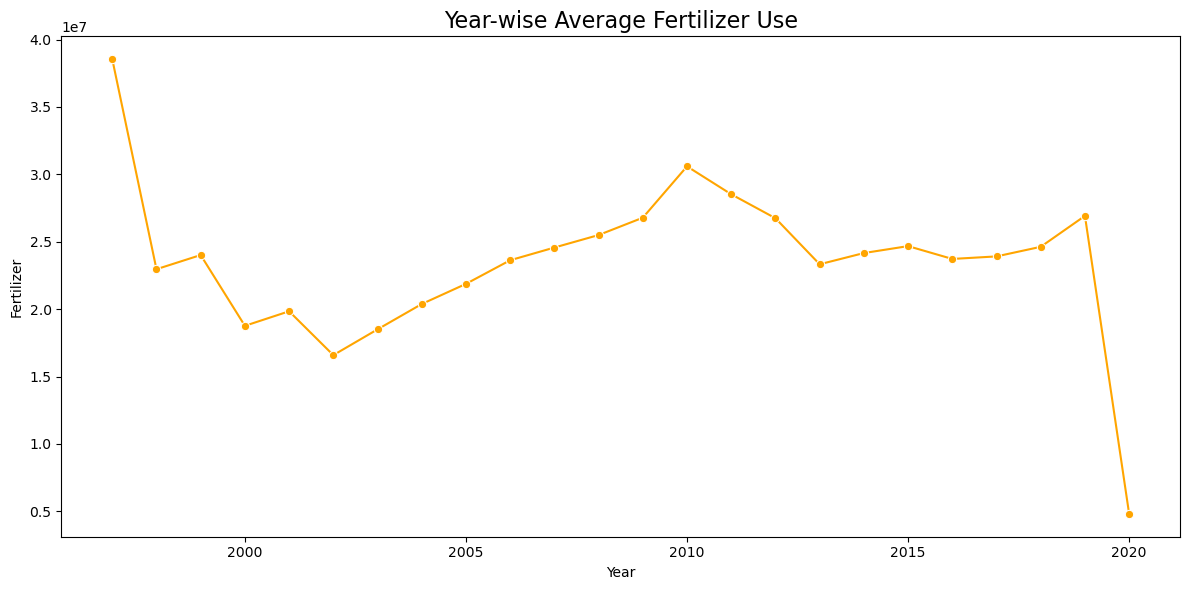

📅 Year with MIN Fertilizer: 2020.0 = 4803181.534054054
📅 Year with MAX Fertilizer: 1997.0 = 38548161.433268294


In [75]:
# 10. Year-wise Average Fertilizer
# ===============================
year_fert = df.groupby("crop_year")["fertilizer"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_fert, x="crop_year", y="fertilizer", marker="o", color="orange")
plt.title("Year-wise Average Fertilizer Use", fontsize=16)
plt.ylabel("Fertilizer")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

min_year = year_fert.loc[year_fert["fertilizer"].idxmin()]
max_year = year_fert.loc[year_fert["fertilizer"].idxmax()]
print(f"📅 Year with MIN Fertilizer: {min_year['crop_year']} = {min_year['fertilizer']}")
print(f"📅 Year with MAX Fertilizer: {max_year['crop_year']} = {max_year['fertilizer']}")

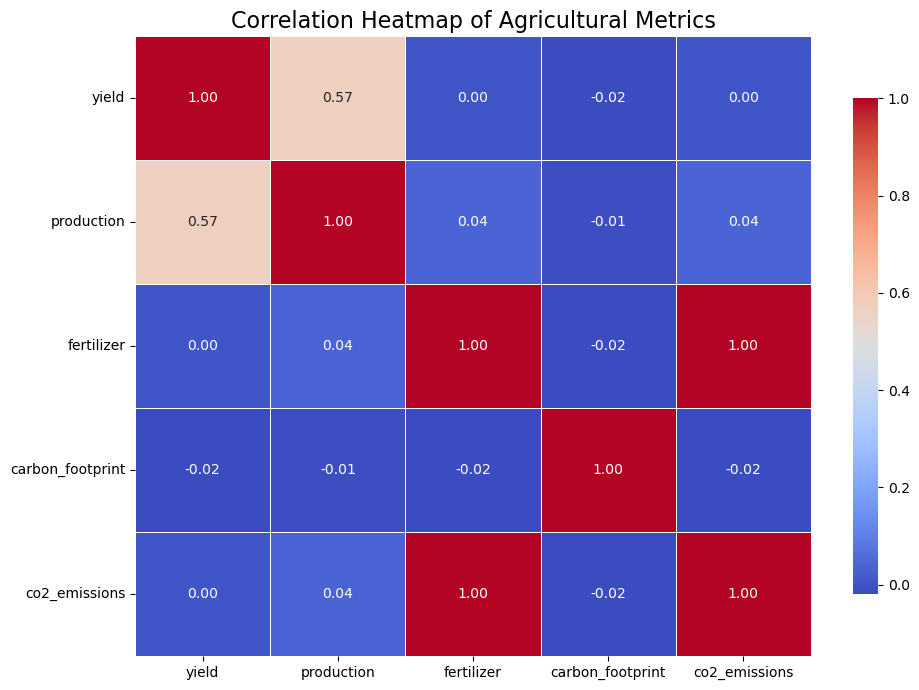

In [76]:
# 11. Correlation Heatmap
# ===============================
plt.figure(figsize=(10, 7))

# Select only numeric columns for correlation
numeric_cols = ["yield", "production", "fertilizer", "carbon_footprint", "co2_emissions"]

corr = df[numeric_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Agricultural Metrics", fontsize=16)
plt.tight_layout()
plt.show()